In [1]:
from scipy import io
import GPy
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb
import GPy.inference.latent_function_inference.exact_gaussian_inference as eg

In [2]:
mat_file = io.loadmat('2015_Dataset4.mat')
t = mat_file['t']
p1 = mat_file['p1']
p2 = mat_file['p2']
t = t*24

In [13]:
le = 288
x_1 = np.arange(0,le/10,0.1)
x_1 = np.reshape(x_1,[len(x_1),1])
print(len(x_1))
start = 8646-288*6
p1_1 = p1[start:start+le]
p2_1 = p2[start:start+le]
y_1 = p1_1
y_2 = p2_1
print(len(y_1))

288
288


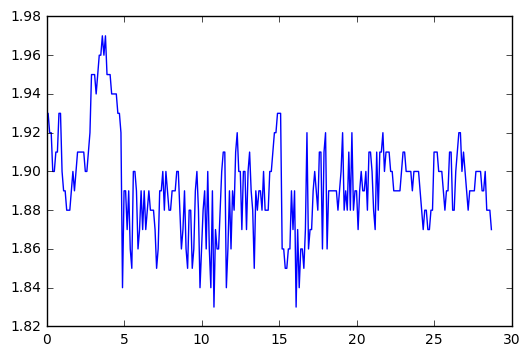

In [4]:
plt.plot(x_1,y_2)
plt.show()

In [5]:
def plot_2outputs(m,xlim):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_1)),ax=ax2)

In [6]:
K1 = GPy.kern.RBF(1)
K2 = GPy.kern.PeriodicMatern52(1, period = 28.8)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2])

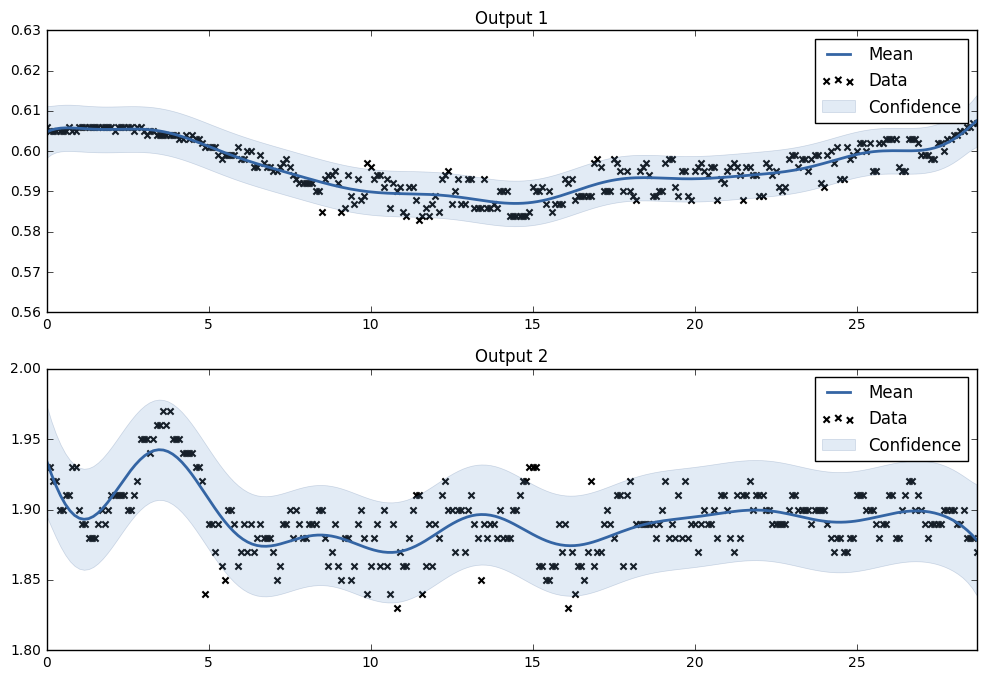

In [7]:
mul = GPy.models.GPCoregionalizedRegression([x_1,x_1],[y_1,y_2],kernel = lcm)
mul['.*periodic_Matern52.period'].constrain_fixed(28.8)
mul.optimize()
plot_2outputs(mul, xlim=(0,x_1[len(x_1)-1]))
plt.show()

In [8]:
mul

gp.,value,constraints,priors
sum.ICM0.rbf.variance,0.0271071930436,+ve,
sum.ICM0.rbf.lengthscale,3.35469644753,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.periodic_Matern52.variance,1.41837818829e-19,+ve,
sum.ICM1.periodic_Matern52.lengthscale,166.355519805,+ve,
sum.ICM1.periodic_Matern52.period,28.8,fixed +ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,7.9394774169e-06,+ve,


In [9]:
def build_XY(input_list,output_list=None):
    num_outputs = len(input_list)
    Y = np.vstack(output_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,Y,I

In [10]:
# start = 8646-288*2
# p1_2 = p1[start:start+le]
# p2_2 = p2[start:start+le]
# y_1 = p1_2
# y_2 = p2_2

In [22]:
lkd = np.zeros(len(x_1))
for i in range(len(x_1)):
    xi = [x_1[i:i+5],x_1[i:i+5]]
    yi = [y_1[i:i+5],y_2[i:i+5]]
    Xi, Yi, Ii = build_XY(xi, yi)
    p, lkd[i], grad = eg.ExactGaussianInference.inference(mul, mul.kern, Xi, mul.likelihood, Yi, Y_metadata = Ii)
plt.plot(x_1, lkd)
plt.show()

In [164]:
x1 = [x_1[10:10+2],x_1[10:10+2]]
y1 = [y_1[10:10+2],y_2[10:10+2]]
X1, Y1, I1 = build_XY(x1, y1)
Y1

array([[ 0.606],
       [ 0.606],
       [ 1.9  ],
       [ 1.89 ]])

In [165]:
Kxx = mul.kern.K(X1)

In [166]:
Kxxx = np.ascontiguousarray(Kxx)
Kxxx

array([[ 0.10337284,  0.10332693,  0.33402198,  0.33387361],
       [ 0.10332693,  0.10337284,  0.33387361,  0.33402198],
       [ 0.33402198,  0.33387361,  1.1805707 ,  1.1800463 ],
       [ 0.33387361,  0.33402198,  1.1800463 ,  1.1805707 ]])

In [167]:
from scipy.linalg import lapack, blas
L, info = lapack.dpotrf(Kxxx, lower=1)

In [171]:
Wi, LW, LWi, W_logdet = GPy.util.linalg.pdinv(Kxxx)

In [172]:
alpha, _ = GPy.util.linalg.dpotrs(LW, Y1, lower=1)

In [175]:
np.dot(Kxxx,alpha)

array([[ 0.606],
       [ 0.606],
       [ 1.9  ],
       [ 1.89 ]])

In [174]:
alpha

array([[-355.23333322],
       [ 363.11166649],
       [ 110.844644  ],
       [-111.46816912]])

In [176]:
alpha*Y1

array([[-215.27139993],
       [ 220.04566989],
       [ 210.6048236 ],
       [-210.67483964]])

In [177]:
Y1*alpha

array([[-215.27139993],
       [ 220.04566989],
       [ 210.6048236 ],
       [-210.67483964]])